# **Movie Rating Prediction with Python**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor


import warnings
warnings.filterwarnings("ignore")

In [2]:
# preview the dataset
df = pd.read_csv('IMDb Movies India.csv', encoding='ISO-8859-1')
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [3]:
#get information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


The dataseet has 15509 entries and 10 columns

In [4]:
# get summary statistics of the datset
df.describe()

,Rating
count,7919.000000
mean,5.841621
std,1.381777
min,1.100000
25%,4.900000
50%,6.000000
75%,6.800000
max,10.000000


In [5]:
df.dtypes

Name         object
Year         object
Duration     object
Genre        object
Rating      float64
Votes        object
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object

In [6]:
df.shape

(15509, 10)

## **Data Preparation**

#### Check for missing values

In [7]:
df.isna().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

#### Dealing with the missing values

The rows from our dataset where the 'Rating' information was not available is droppped

In [8]:
df.dropna(subset=['Rating'], inplace=True)

In [9]:
df.isna().sum()

Name           0
Year           0
Duration    2068
Genre        102
Rating         0
Votes          0
Director       5
Actor 1      125
Actor 2      200
Actor 3      292
dtype: int64

The missing entries in Genre will be replaced by Unknown

In [10]:
df['Genre'].fillna('Unknown', inplace=True)

In [11]:
df.isna().sum()

Name           0
Year           0
Duration    2068
Genre          0
Rating         0
Votes          0
Director       5
Actor 1      125
Actor 2      200
Actor 3      292
dtype: int64

Impute missing values in 'Duration' with the median

In [12]:
# Extract numeric values from 'Duration' and convert to integers
df['Duration'] = df['Duration'].str.extract(r'(\d+)').astype(float)

# Impute missing values in 'Duration' with the median
df['Duration'].fillna(df['Duration'].median(), inplace=True)


The missing entries in the subset Actor 1, actor 2 and actor 3 will be dropped

In [13]:
df.dropna(subset=['Actor 1', 'Actor 2', 'Actor 3'], inplace=True)

In [14]:
df.isna().sum()

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

#### Check for duplicates

In [15]:
df.duplicated().sum()

0

The data has no duplicates

#### Check Data Types

In [16]:
df.dtypes

Name         object
Year         object
Duration    float64
Genre        object
Rating      float64
Votes        object
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object

Change the data type of both Year and Votes column to numerical data types

In [17]:
df['Year'] = df['Year'].str.extract(r'(\d+)').astype(int)

In [18]:
df['Votes'] = df['Votes'].str.extract(r'(\d+)').astype(int)

In [19]:
df.dtypes

Name         object
Year          int64
Duration    float64
Genre        object
Rating      float64
Votes         int64
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object

In [20]:
# preview the clean dataset
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110.0,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,1997,147.0,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,2005,142.0,"Drama, Romance, War",7.4,1,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,2012,82.0,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


#### Check for outliers and remove them

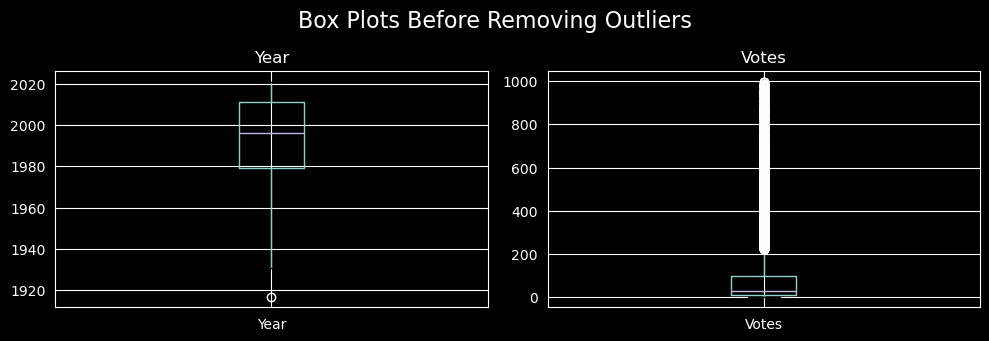

Number of rows with outliers before removal: 781


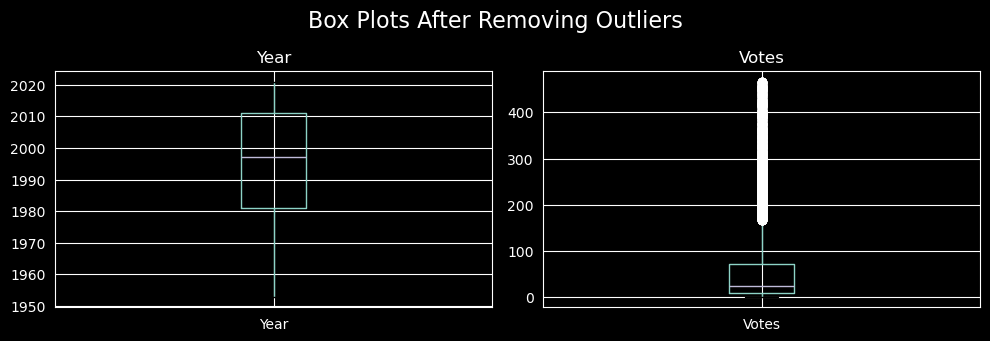

Number of rows after removing outliers: 6846


In [21]:
# Set the dark_background style
plt.style.use('dark_background')

# Define the numerical columns you want to check for outliers
numerical_columns = ['Year', 'Votes']

# Create box plots before removing outliers
plt.figure(figsize=(10, 6))
plt.suptitle('Box Plots Before Removing Outliers', fontsize=16)

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    df.boxplot(column=[column])
    plt.title(f'{column}')

plt.tight_layout()
plt.show()

# Calculate z-scores for numerical columns
z_scores = pd.DataFrame()
for column in numerical_columns:
    z_scores[column] = (df[column] - df[column].mean()) / df[column].std()

# Set a z-score threshold to identify outliers (e.g., 2 or -2 for a 95% confidence interval)
z_score_threshold = 2

# Identify outliers based on z-scores
outliers = z_scores[(z_scores.abs() > z_score_threshold).any(axis=1)]

# Display the number of rows with outliers before removal
print("Number of rows with outliers before removal:", len(outliers))

# Remove outliers and create a new DataFrame (df_cleaned)
df = df[~((z_scores.abs() > z_score_threshold).any(axis=1))]

# Create box plots after removing outliers
plt.figure(figsize=(10, 6))
plt.suptitle('Box Plots After Removing Outliers', fontsize=16)

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    df.boxplot(column=[column])
    plt.title(f'{column}')

plt.tight_layout()
plt.show()

# Display the number of rows after removing outliers
print("Number of rows after removing outliers:", len(df))


## **Exploratory Data Analysis**

### Univariate analysis
Univariate analysis focuses on understanding the distribution and characteristics of individual variables

#### Rating Analysis

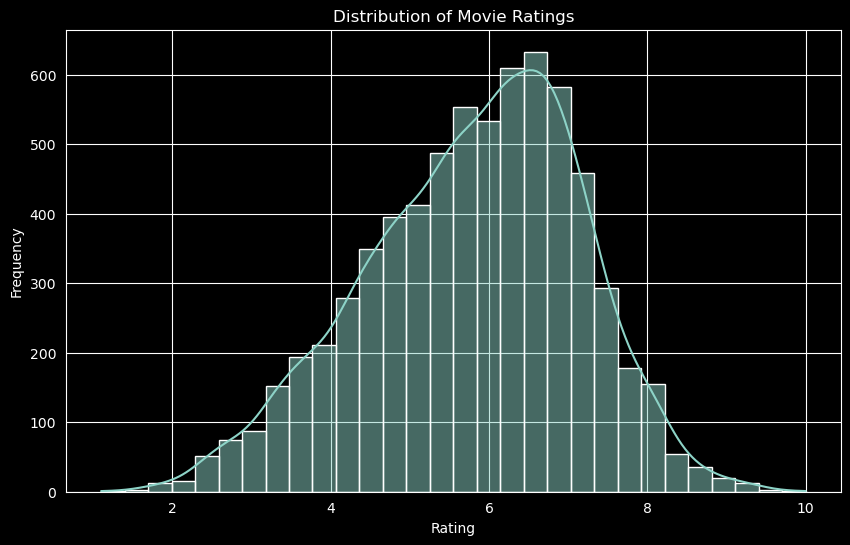

In [22]:
# rating analysis
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Rating', bins=30, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


$Inferences$ 
*  Rating Distribution: The histogram shows a slightly normal distribution with a peak around a 7 rating value.
*  Common Rating Range falls between 5 to 7.
* All ratings are positive 
* There are few movies rated below 2 and above 8

#### Votes Analysis

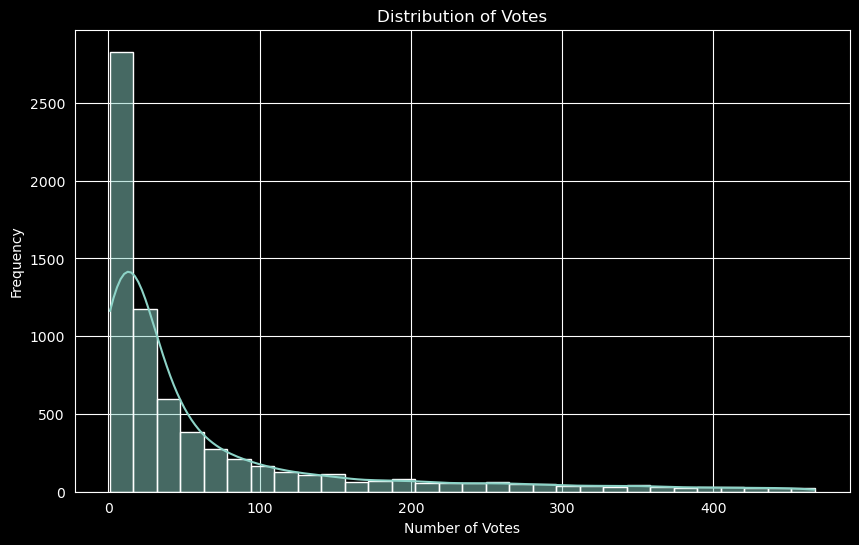

In [23]:
# Votes Analysis
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Votes', bins=30, kde=True)
plt.title('Distribution of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.show()

$Inference$ 
* The distribution of votes is right-skewed, with the majority of movies receiving a relatively low number of votes. This suggests that many movies in the dataset may not be widely recognized or popular, as they have received fewer votes
* The long tail towards higher vote counts indicates that there are a smaller number of movies that have garnered a significant number of votes
* Popularity Range is between 0 and 50



#### Top 10 Directors with the Most Movies Directed

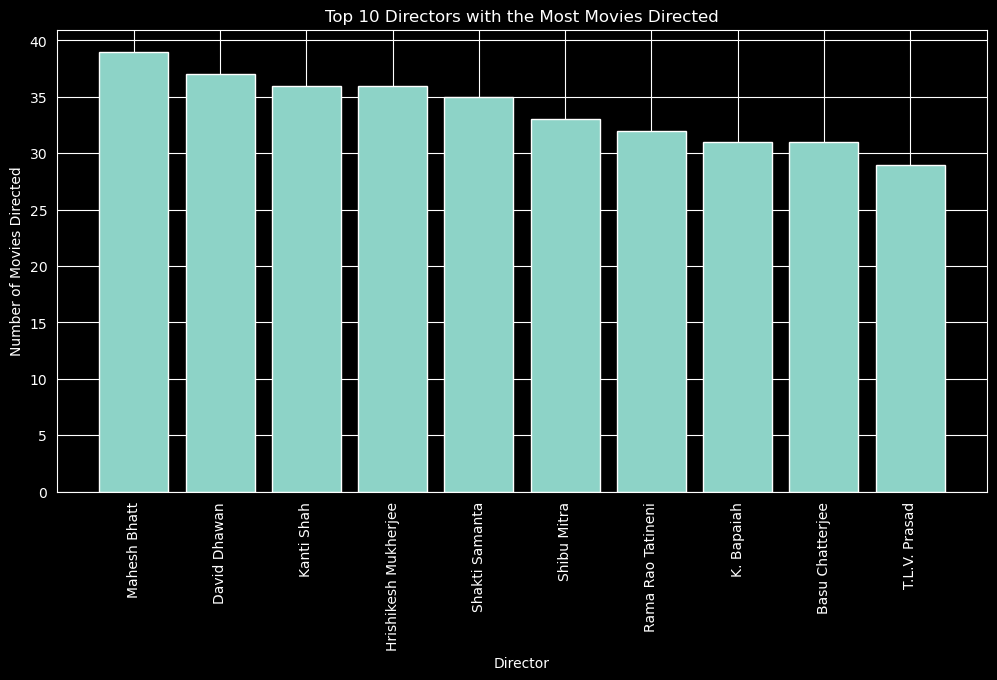

In [24]:

# Count the number of movies directed by each director
director_counts = df['Director'].value_counts()

# Select the top 10 directors with the most movies directed
top_10_directors = director_counts.head(10)

# Create a bar plot to visualize the top 10 directors with the most movies directed
plt.figure(figsize=(12, 6))
plt.bar(top_10_directors.index, top_10_directors.values),
plt.title('Top 10 Directors with the Most Movies Directed')
plt.xlabel('Director')
plt.ylabel('Number of Movies Directed')
plt.xticks(rotation=90)
plt.show()


$Inference$ 
* The above directors are quite prolific in their careers.
* Mahesh Bhatt directed the most movies

#### Top 10 Actors with the Most Movie Appearances

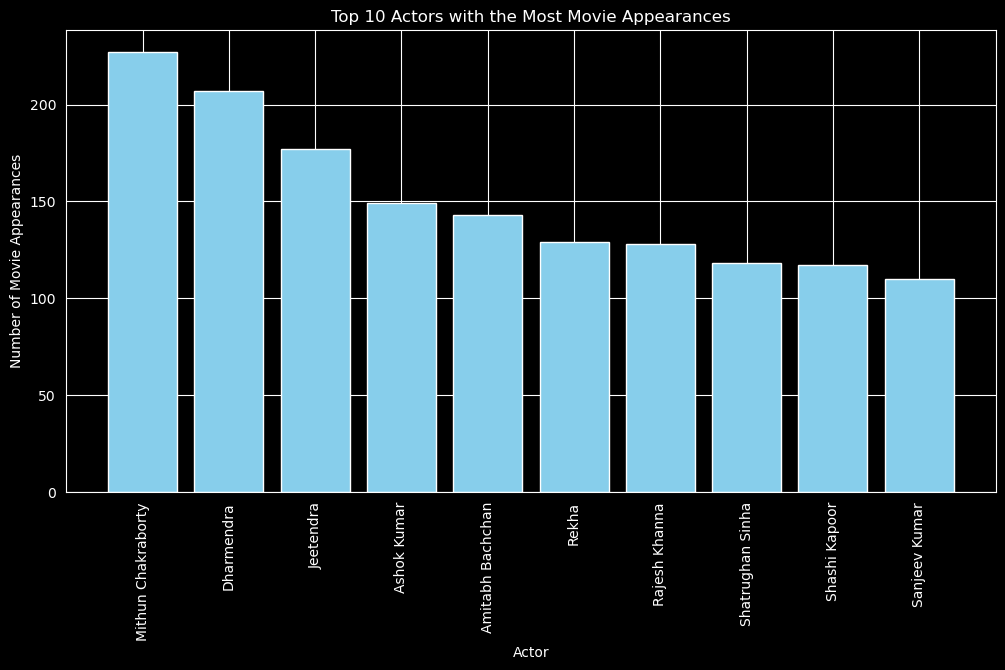

In [25]:
# Count the number of movies in which each actor starred
actor_counts = df[['Actor 1', 'Actor 2', 'Actor 3']].stack().value_counts()

# Select the top 10 actors with the most movie appearances
top_10_actors = actor_counts.head(10)

# Create a bar plot to visualize the top 10 actors with the most movie appearances
plt.figure(figsize=(12, 6))
plt.bar(top_10_actors.index, top_10_actors.values,  color='skyblue')
plt.title('Top 10 Actors with the Most Movie Appearances')
plt.xlabel('Actor')
plt.ylabel('Number of Movie Appearances')
plt.xticks(rotation=90)
plt.show()

$inference$ 
* Prolific Actors: The top 10 actors have made a substantial number of movie appearances, indicating their prolific careers in the film industry
* The actor who appeared the most in these movies is Mithun Chakraborty
* Collaboration Opportunities: Filmmakers and producers can consider collaborating with these experienced actors to enhance the credibility and appeal of their projects


### Bivariate Analysis
Bivariate analysis helps you understand the relationships between two variables

#### Top 10 Directors with the Highest-Rated Movies

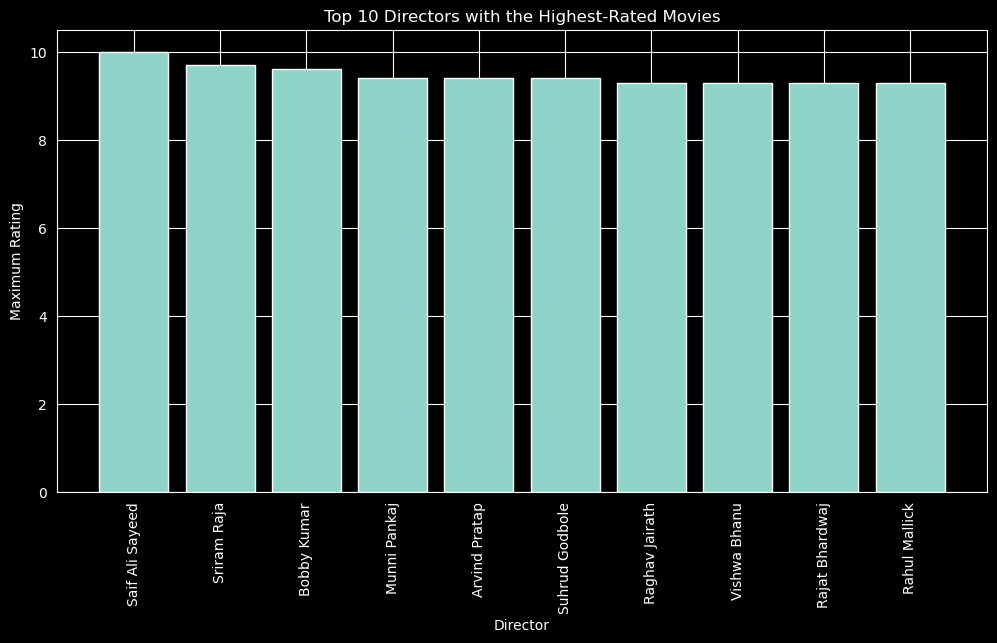

In [26]:
# Group the data by director and find the maximum rating within each group
directors_max_rating = df.groupby('Director')['Rating'].max()

# Sort the directors by their highest rating in descending order and select the top 10
top_10_directors = directors_max_rating.sort_values(ascending=False).head(10)

# Create a bar plot to visualize the top 10 directors with the highest-rated movies
plt.figure(figsize=(12, 6))
plt.bar(top_10_directors.index, top_10_directors.values)
plt.title('Top 10 Directors with the Highest-Rated Movies')
plt.xlabel('Director')
plt.ylabel('Maximum Rating')
plt.xticks(rotation=90)
plt.show()


$Inference$ 
* Saif Ali Sayeed has directed the most succcessful Movies among other directors.This shows that the likelyhood of a movie to be rated high if directed by him is high.
*  Stakeholders in the film industry might consider collaborating with these directors to ensure the production of well-received movies.

#### Top 10 Highly Rated Movie Genres

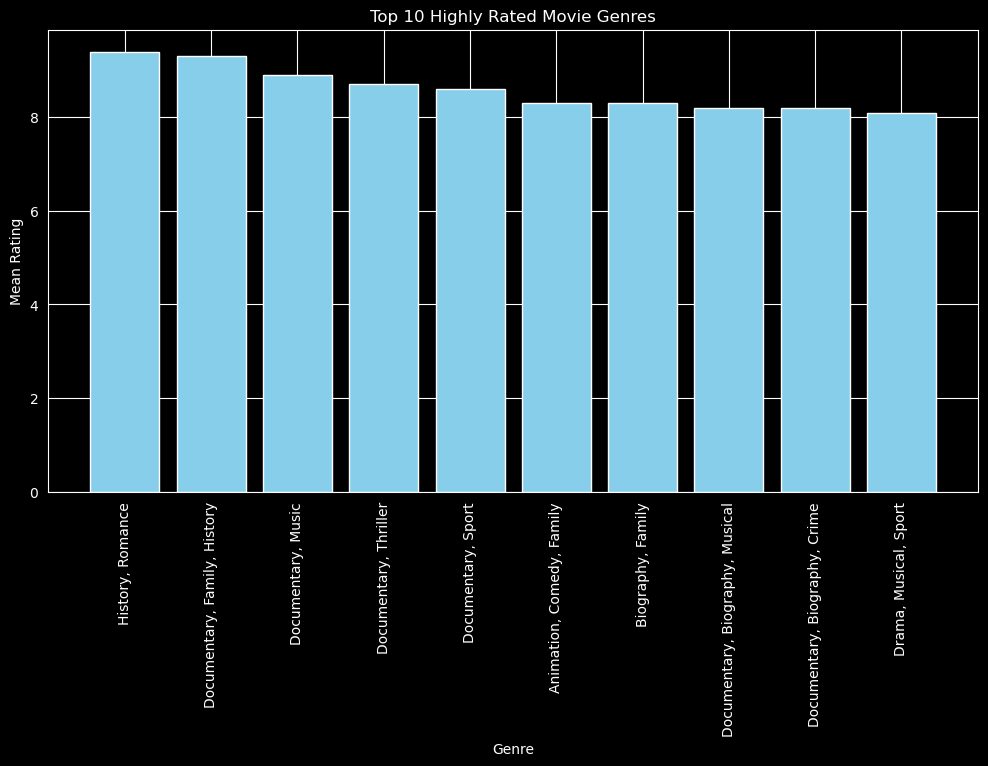

In [27]:
# Group the data by genre and calculate the mean rating for each genre
genre_mean_ratings = df.groupby('Genre')['Rating'].mean()

# Sort the genres by mean rating in descending order and select the top 10
top_10_genres = genre_mean_ratings.sort_values(ascending=False).head(10)

# Create a bar plot to visualize the top 10 highly rated genres
plt.figure(figsize=(12, 6))
plt.bar(top_10_genres.index, top_10_genres.values, color='skyblue')
plt.title('Top 10 Highly Rated Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Mean Rating')
plt.xticks(rotation=90)
plt.show()


$inference$
* Genre Popularity: The top 10 highly rated genres are likely to be popular among audiences, as reflected in their mean ratings
* History, Romance genre has the highes rating hence wise to investing in the genre
* Critical Acclaim: High mean ratings often indicate that these genres receive positive reviews and critical acclaim from both audiences and critics.
* Filmmakers, actors, and production companies may consider collaborating within these genres to create well-received movies.

#### Top 10 Years with Highest Average Ratings 

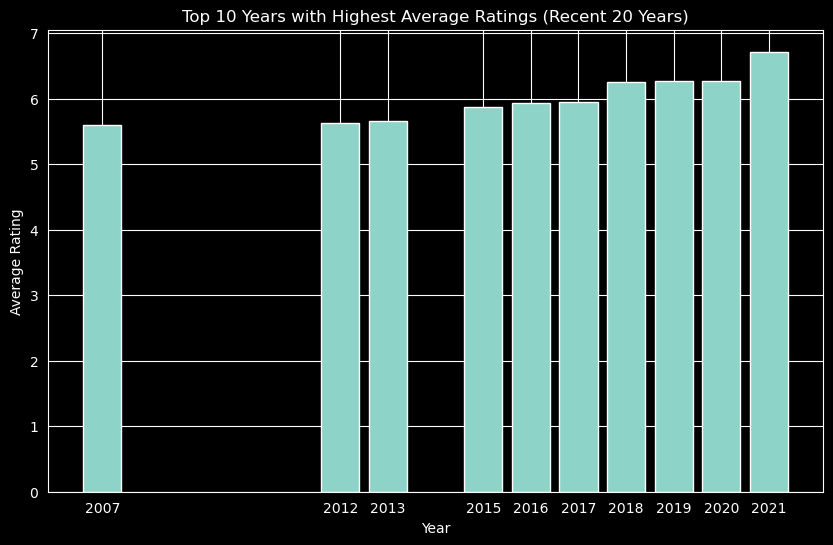

In [28]:
# Filter the DataFrame for the most recent 20 years
recent_years = df[df['Year'] >= (max(df['Year']) - 19)]

# Calculate the average rating per year
average_ratings = recent_years.groupby('Year')['Rating'].mean().reset_index()

# Sort the DataFrame by average rating in descending order and select the top 10 years
top_10_years = average_ratings.nlargest(10, 'Rating')

# Plot the top 10 years and their average ratings
plt.figure(figsize=(10, 6))
plt.bar(top_10_years['Year'], top_10_years['Rating'])
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Top 10 Years with Highest Average Ratings (Recent 20 Years)')
plt.xticks(top_10_years['Year'])
plt.show()


* Consistency: Over the recent 20 years, there seems to be a range of years with high average ratings, indicating some consistency in the quality of movies during those years

#### Duration vs Rating

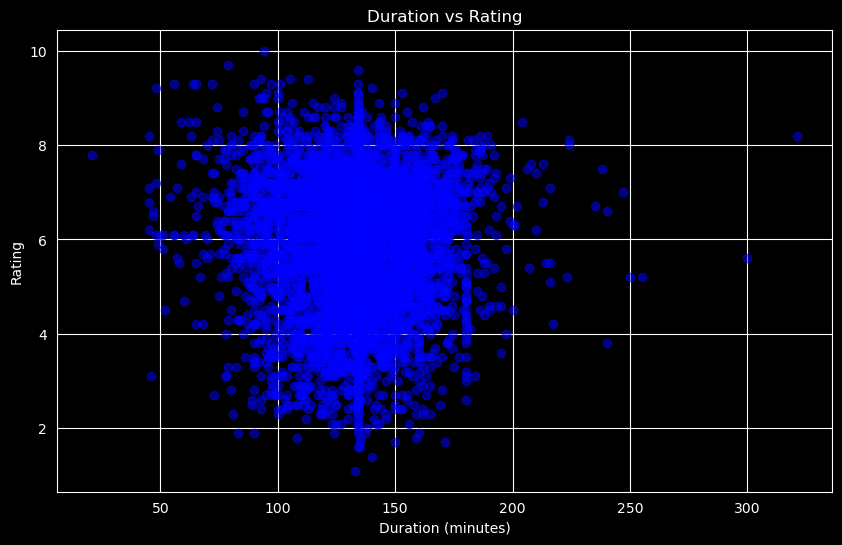

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Duration'], df['Rating'], alpha=0.5, color='blue')
plt.xlabel('Duration (minutes)')
plt.ylabel('Rating')
plt.title('Duration vs Rating')
plt.show()

There doesn't appear to be a strong linear relationship between movie duration and ratings.you can't easily predict a movie's rating based solely on its duration.

### Multivariate Analysis
Multivariate analysis involves exploring the relationships between more than two variables.

#### Correlation Matrix

In [30]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap to visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

ValueError: could not convert string to float: '#Gadhvi (He thought he was Gandhi)'

The variables are not Highly correlated. The absence of strong correlations between numerical variables is a positive sign, as it reduces the risk of multicollinearity in regression analysis

#### Pairplot

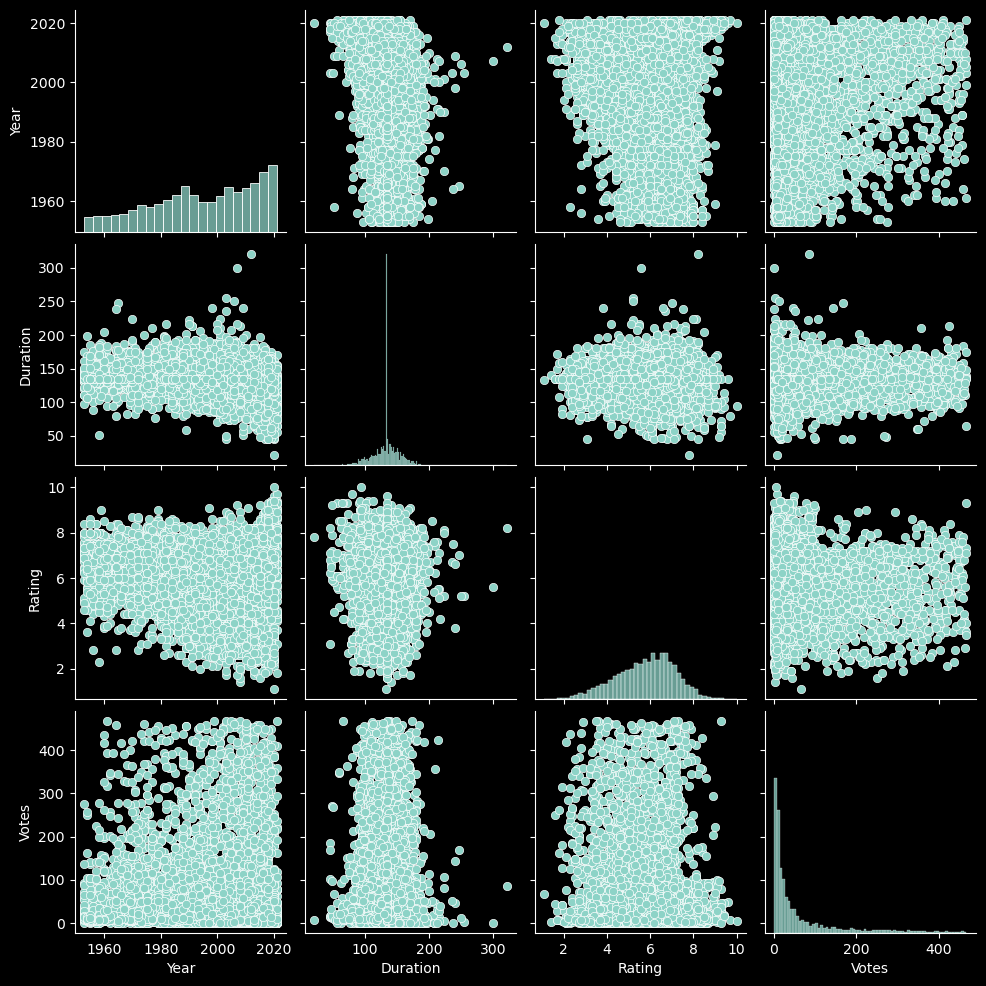

In [31]:
# Select the numerical variables for the pair plot
numerical_columns = df.select_dtypes(include=['number'])

# Create a pair plot for the numerical variables
sns.pairplot(numerical_columns)
plt.show()

No strong correlation between variables

## **Data Preprocessing**

### Assign the variables  
assigning y/ target variable to Rating column for prediction analysis and the rest of the features to independent variable X

In [32]:
X = df.drop('Rating', axis=1)
y = df['Rating']

In [33]:
X.head()

,Name,Year,Duration,Genre,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019,109.0,Drama,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019,110.0,"Comedy, Romance",35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
6,...Yahaan,2005,142.0,"Drama, Romance, War",1,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,2012,82.0,"Horror, Mystery, Thriller",326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
9,@Andheri,2014,116.0,"Action, Crime, Thriller",11,Biju Bhaskar Nair,Augustine,Fathima Babu,Byon


### Check for mutlicollinearity X  

In [34]:
X.corr()

,Year,Duration,Votes
Year,1.000000,-0.295635,0.064510
Duration,-0.295635,1.000000,0.007258
Votes,0.064510,0.007258,1.000000


### One-hot encode the categorical variables
One-hot encoding is used to convert categorical variables into a binary format, which is suitable for machine learning algorithms

In [35]:
df.columns

Index(['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3'],
      dtype='object')

In [36]:

# Specify the categorical columns to be one-hot encoded
categorical_columns = ['Name', 'Genre', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3']

# Initialize the OneHotEncoder
ohe = OneHotEncoder(sparse=False)

# Fit and transform the categorical columns
X_categorical_encoded = ohe.fit_transform(X[categorical_columns])

# Retrieve feature names for the encoded columns
feature_names = []
for i, col in enumerate(categorical_columns):
    categories = ohe.categories_[i]
    for category in categories:
        feature_names.append(f"{col}_{category}")

# Create a DataFrame for the encoded features
X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns=feature_names)
X_categorical_encoded_df.head()

,Name_#Gadhvi (He thought he was Gandhi),Name_#Yaaram,Name_'Ferry',Name_'Sambandh',Name_...Yahaan,Name_102 Not Out,Name_10ml LOVE,Name_12 O'Clock,Name_127 B,Name_13B: Fear Has a New Address,...,Actor 3_Zareen Khan,Actor 3_Zarina Wahab,Actor 3_Zarine Ali,Actor 3_Zayed Khan,Actor 3_Zeenat Aman,Actor 3_Zeeshan Khan,Actor 3_Zeishan Quadri,Actor 3_Zenobia Shroff,Actor 3_Zoya Hussain,Actor 3_Zulfi Sayed
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Scaling Numerical Features  


In [37]:
# Specify the numerical columns to be scaled
numerical_columns = ['Year', 'Duration', 'Votes']

# Initialize the StandardScaler
scaler = MinMaxScaler()

# Fit and transform the selected numerical columns
X_numeric_scaled = scaler.fit_transform(X[numerical_columns])

# Create a DataFrame for the scaled features
X_numeric_scaled_df = pd.DataFrame(X_numeric_scaled, columns=numerical_columns)
X_numeric_scaled_df.head()

,Year,Duration,Votes
0,0.970588,0.293333,0.015021
1,0.970588,0.296667,0.072961
2,0.764706,0.403333,0.000000
3,0.867647,0.203333,0.697425
4,0.897059,0.316667,0.021459


In [38]:
# combine the scaled columns and onehotencoded columns
X_final = pd.concat([X_numeric_scaled_df, X_categorical_encoded_df, ], axis=1)
X_final.head()

,Year,Duration,Votes,Name_#Gadhvi (He thought he was Gandhi),Name_#Yaaram,Name_'Ferry',Name_'Sambandh',Name_...Yahaan,Name_102 Not Out,Name_10ml LOVE,...,Actor 3_Zareen Khan,Actor 3_Zarina Wahab,Actor 3_Zarine Ali,Actor 3_Zayed Khan,Actor 3_Zeenat Aman,Actor 3_Zeeshan Khan,Actor 3_Zeishan Quadri,Actor 3_Zenobia Shroff,Actor 3_Zoya Hussain,Actor 3_Zulfi Sayed
0,0.970588,0.293333,0.015021,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.970588,0.296667,0.072961,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.764706,0.403333,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.867647,0.203333,0.697425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.897059,0.316667,0.021459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Scaling y

In [39]:
# Instantiate StandardScaler
scaler = MinMaxScaler()

# Reshape 'Rating' to a 2D array for StandardScaler
y_scaled = scaler.fit_transform(df['Rating'].values.reshape(-1, 1))

# Convert 'y_scaled' back to a DataFrame
y = pd.DataFrame(y_scaled, columns=['Rating'])
y


,Rating
0,0.662921
1,0.370787
2,0.707865
3,0.505618
4,0.325843
...,...
6841,0.426966
6842,0.471910
6843,0.528090
6844,0.393258


### Train-Test Split 


In [40]:
# Split the data into training and testing data 

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

## **Modeling**

In [41]:
from sklearn.linear_model import LinearRegression
# Create a Linear Regression model
lr_model = LinearRegression()

# Fit the model on the training data
lr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_test = lr_model.predict(X_test)
y_pred_train = lr_model.predict(X_train)

### Baseline Model Evaluation

In [42]:
# Evaluate the model
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"Test Mean Squared Error : {mse_test}")
print(f"Test R-squared (R^2) Score: {r2_test}")

print(f"Train Mean Squared Error : {mse_train}")
print(f"Train R-squared (R^2) Score: {r2_train}")

Test Mean Squared Error : 0.019581613790075256
Test R-squared (R^2) Score: 0.15972061607163157
Train Mean Squared Error : 1.298304960202019e-29
Train R-squared (R^2) Score: 1.0


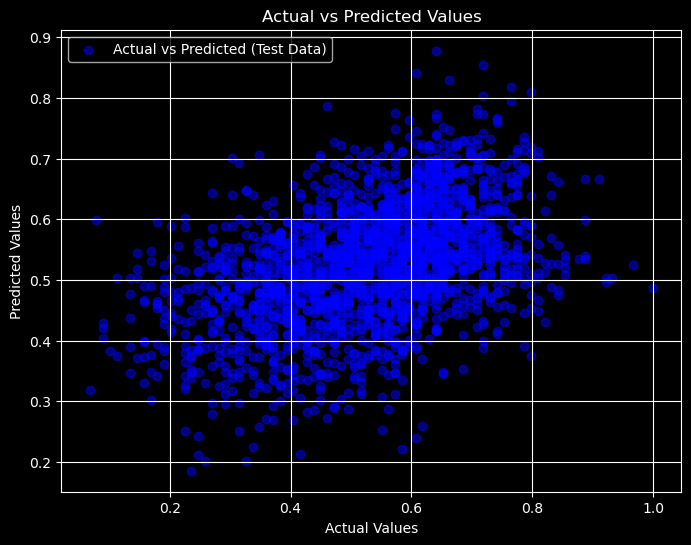

In [43]:
# Create a scatter plot for the test data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='blue', label='Actual vs Predicted (Test Data)')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [44]:
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_test = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

#### Random Forest model Evaluation

In [45]:
# Evaluate the model
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("Random Forest Regressor Model Evaluation:")
print(f"Test Mean Squared Error: {mse_test}")
print(f"Test R-squared (R^2) Score: {r2_test}")
print(f"Train Mean Squared Error: {mse_train}")
print(f"Train R-squared (R^2) Score: {r2_train}")

Random Forest Regressor Model Evaluation:
Test Mean Squared Error: 0.015928808092375697
Test R-squared (R^2) Score: 0.3164685406389469
Train Mean Squared Error: 0.002355830705301668
Train R-squared (R^2) Score: 0.8994964674176646


### Third Model: Gradient Boosting Regressor

In [46]:
# Create a Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor(random_state=42)

# Fit the model on the training data
gb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_test = gb_model.predict(X_test)
y_pred_train = gb_model.predict(X_train)


### Model Evaluation

In [47]:
# Evaluate the model
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("Gradient Boosting Regressor Model Evaluation:")
print(f"Test Mean Squared Error: {mse_test}")
print(f"Test R-squared (R^2) Score: {r2_test}")
print(f"Train Mean Squared Error: {mse_train}")
print(f"Train R-squared (R^2) Score: {r2_train}")

Gradient Boosting Regressor Model Evaluation:
Test Mean Squared Error: 0.017397743710507674
Test R-squared (R^2) Score: 0.2534340875306963
Train Mean Squared Error: 0.016082418329815617
Train R-squared (R^2) Score: 0.31389812902264735


### Hyperparameter Tuning of Random forest model

In [48]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 20, 50],
    'max_depth': [None, 3, 10, 20],
    'min_samples_split': [1, 3, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}


# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred_test = best_rf_model.predict(X_test)
y_pred_train = best_rf_model.predict(X_train)

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}


In [49]:
# Evaluate the model on the test data
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Evaluate the model on the training data
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("Tuned Random Forest Regressor Model Evaluation (Test Data):")
print(f"Test Mean Squared Error: {mse_test}")
print(f"Test R-squared (R^2) Score: {r2_test}")

print("Tuned Random Forest Regressor Model Evaluation (Training Data):")
print(f"Train Mean Squared Error: {mse_train}")
print(f"Train R-squared (R^2) Score: {r2_train}")

Tuned Random Forest Regressor Model Evaluation (Test Data):
Test Mean Squared Error: 0.01663485317198122
Test R-squared (R^2) Score: 0.2861709803419872
Tuned Random Forest Regressor Model Evaluation (Training Data):
Train Mean Squared Error: 0.0027700917407643957
Train R-squared (R^2) Score: 0.8818234243668531


The tuned Random Forest performed better than the tuned model interms of avoiding overfitting,  due to its more balanced performance between training and test data.This will be the final model used for the prediction

### Most important features

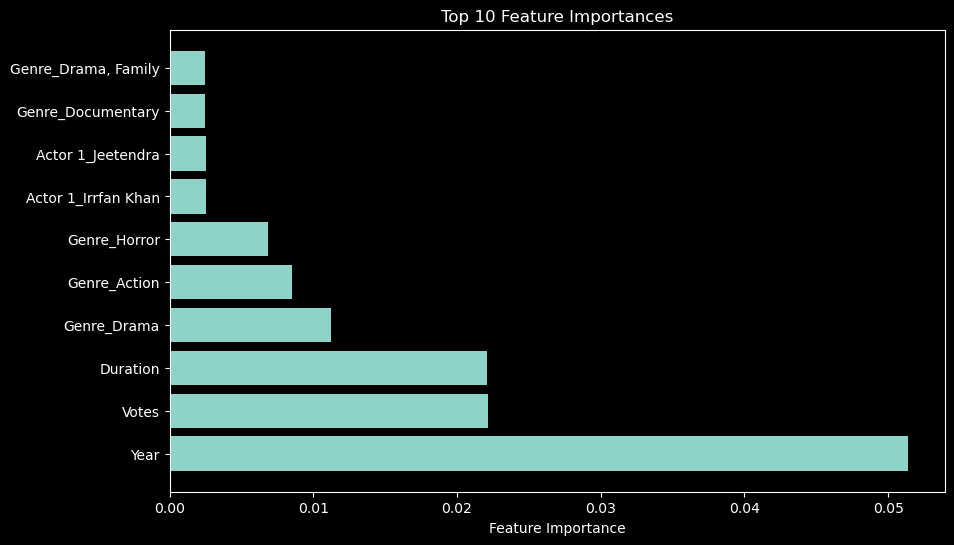

In [50]:
# Get feature importances from the best model
feature_importances = best_rf_model.feature_importances_

# Get the column names of your feature data 
feature_names = X_final.columns 
# Sort feature importances in descending order and get the top 10 features
top_indices = np.argsort(feature_importances)[::-1][:10]
top_features = [feature_names[i] for i in top_indices]
top_importances = [feature_importances[i] for i in top_indices]

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(10), top_importances, align='center')
plt.yticks(range(10), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances')
plt.show()